## PROYECTO FINAL INTEGRADOR - ANÁLISIS Y RECOMENDACIÓN DE VINOS
---------------------

<img src="https://raw.githubusercontent.com/RodrigoVelasco19/Imagenes/main/Vino2.jpg" width="70%">

#### *Objetivo: Aplicar técnicas de exploración y transformación de datos (EDA y ETL), Machine Learning y Procesamiento de Lenguaje Natural (NLP) para extraer información valiosa sobre vinos y construir un sistema de recomendación basado en reseñas.*
---

### Importación de librerias
---

In [38]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

### Análisis de Sentimiento en Reseñas (NLP)
---

Se busca realizar un análisis mediante la aplicación de Procesamiento de Lenguaje Natural (NLP) sobre las descripciones de los vinos, con el objetivo de identificar las palabras más frecuentes en los vinos mejor y peor valorados.

Adicionalmente, se elabora un modelo de análisis de sentimiento de las descripciones, para clasificar las mismas como positivas o negativas y como objetivas o subjetivas.

In [39]:
# Se descarga el dataframe df_clean proveniente del proceso de ETL y EDA

drive.mount('/content/drive')
# Ruta del archivo en Google Drive
file_path = "/content/drive/My Drive/Proyecto-Final-Integrador-Analisis-y-Recomendaciones-de-Vinos/data/df_clean.pkl"

# Cargar el DataFrame
df_clean = pd.read_pickle(file_path)

# Verificar que se cargó correctamente
df_clean.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,pais,descripcion,puntuacion,precio,provincia,variedad,bodega
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot,Tandem


#### Limpieza de datos
----

Se utilizarán las librerías TextBlob en conjunto con NLTK para llevar a cabo la limpieza: eliminación de stopwords y lematización.

In [40]:
# Configuración inicial

# Descargar stopwords de NLTK
nltk.download('stopwords')

# Definir stopwords en inglés
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Crear df_clean_nlp como copia de df_clean
df_clean_nlp = df_clean.copy()

Se procede a eliminar de la descripción de los vinos las stopwords

In [42]:
# Eliminación de Stopwords
def remove_stopwords(text):
    words = text.split()  # Tokenizar manualmente
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

# Aplicar al DataFrame
df_clean_nlp["descripcion"] = df_clean_nlp["descripcion"].apply(remove_stopwords)

Se aplica la lematización convirtiendo las palabras a su forma base o "lema", teniendo en cuenta su significado y contexto gramatical.

In [43]:
nltk.download('wordnet')

def lemmatize_text(text):
    return " ".join([Word(word).lemmatize() for word in text.split()])

# Aplicar lematización al DataFrame
df_clean_nlp["descripcion"] = df_clean_nlp["descripcion"].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Análsis de frecuencia de palabras según puntuación
----

Para tal fin se dividiran los vinos en 4 grupos. Se puede observar del análisis de distribución de las puntuaciones, que dichos valores son enteros y varian entre 80 y 100. Los grupos a conformar serán:

- Grupo 1: puntuación 80 a 85
- Grupo 2: puntuación 86 a 90
- Grupo 3: puntuación 91 a 95
- Grupo 4: puntuación 96 a 100

In [44]:
# Crear los grupos de puntuación
def asignar_grupo(puntuacion):
    if 80 <= puntuacion <= 85:
        return 'Grupo 1 (80-85)'
    elif 86 <= puntuacion <= 90:
        return 'Grupo 2 (86-90)'
    elif 91 <= puntuacion <= 95:
        return 'Grupo 3 (91-95)'
    elif 96 <= puntuacion <= 100:
        return 'Grupo 4 (96-100)'
    else:
        return 'Fuera de rango'

# Aplicar la función de agrupación a la columna 'puntuacion'
df_clean_nlp['grupo'] = df_clean_nlp['puntuacion'].apply(asignar_grupo)

In [45]:
# Definir un orden explícito para los grupos
orden_grupos = ['Grupo 1 (80-85)', 'Grupo 2 (86-90)', 'Grupo 3 (91-95)', 'Grupo 4 (96-100)']

# Inicializar el CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Limitar a las 20 palabras más comunes

In [46]:
# Función para analizar las palabras más comunes en cada grupo
def analizar_frecuencia_por_grupo(grupo):
    # Filtrar el DataFrame por el grupo
    df_grupo = df_clean_nlp[df_clean_nlp['grupo'] == grupo]

    # Vectorizar las descripciones del grupo
    X = vectorizer.fit_transform(df_grupo['descripcion'])

    # Obtener las palabras más comunes
    palabras = vectorizer.get_feature_names_out()
    frecuencias = X.sum(axis=0).A1  # Sumar las frecuencias de cada palabra

    # Crear un DataFrame con las palabras y sus frecuencias
    palabras_frecuencia = pd.DataFrame(list(zip(palabras, frecuencias)), columns=['Palabra', 'Frecuencia'])
    return palabras_frecuencia.sort_values(by='Frecuencia', ascending=False)


Frecuencia de palabras para Grupo 1 (80-85):
    Palabra  Frecuencia
19     wine       15766
7    flavor       12788
9     fruit       10931
6    finish        9381
8   flavors        7384


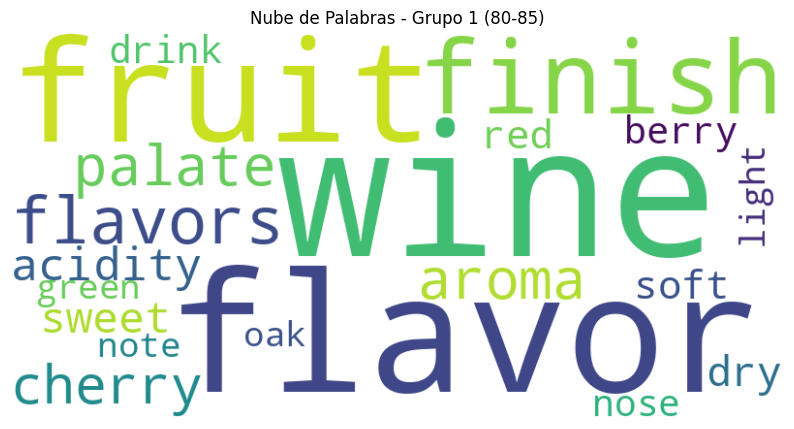

Frecuencia de palabras para Grupo 2 (86-90):
   Palabra  Frecuencia
19    wine       50005
11   fruit       38025
8   flavor       30919
7   finish       25994
14  palate       23665


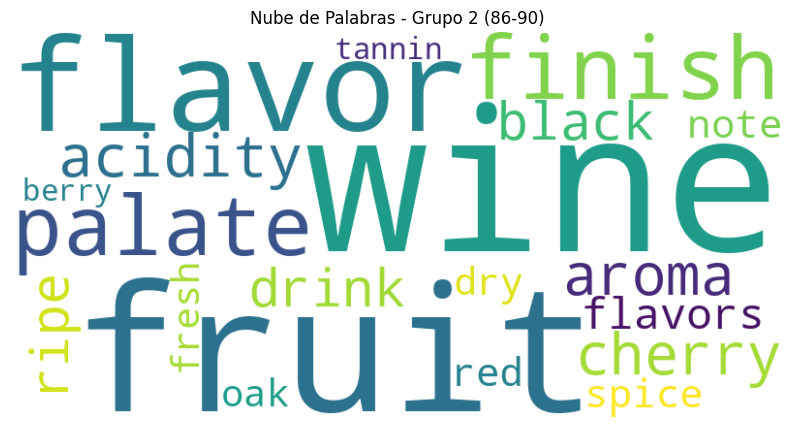

Frecuencia de palabras para Grupo 3 (91-95):
   Palabra  Frecuencia
19    wine       21251
9    fruit       14742
7   flavor       10427
2    black        9219
13  palate        8812


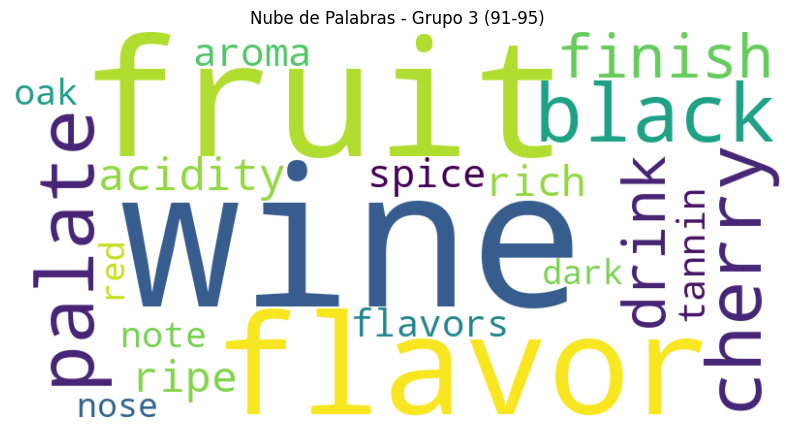

Frecuencia de palabras para Grupo 4 (96-100):
    Palabra  Frecuencia
19     wine         268
9     fruit         130
7    flavor         113
0   acidity         102
2    cherry         102


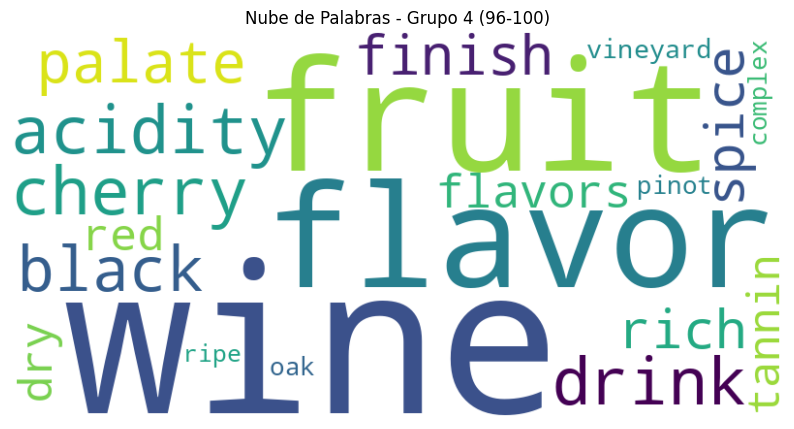

In [47]:
# Analizar frecuencia de palabras por grupo en el orden definido
for grupo in orden_grupos:
    print(f"Frecuencia de palabras para {grupo}:")
    palabras_frecuencia = analizar_frecuencia_por_grupo(grupo)
    print(palabras_frecuencia.head())  # Mostrar las 5 palabras más comunes

    # Visualizar las palabras más comunes en una nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(palabras_frecuencia.values))

    # Mostrar la nube de palabras para cada grupo
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de Palabras - {grupo}')
    plt.axis('off')
    plt.show()

#### Construcción de un modelo de análisis de sentimiento
----

Utilizando la librería TextBlob se calcula la polaridad y la subjetividad de cada reseña. Luego podremos clasificar la misma según:

- La polaridad se mide entre -1 (negativo) y +1 (positivo). Si la polaridad es mayor que 0, podemos clasificar la reseña como positiva, y si es menor que 0, como negativa.

- La subjetividad se mide entre 0 (objetivo) y 1 (subjetivo). Si la subjetividad es mayor que 0.5, podemos clasificarla como subjetiva; si es menor o igual a 0.5, como objetiva.

In [48]:
# Función para calcular polaridad y subjetividad
def obtener_polaridad_subjetividad(texto):
    blob = TextBlob(texto)
    polaridad = blob.sentiment.polarity
    subjetividad = blob.sentiment.subjectivity
    return polaridad, subjetividad

Se crearán 4 nuevas columnas en el dataframe 'df_clean_nlp', en las cuales se incluirán los valores calculados para polaridad y subjetividad, y las respectivas clasificaciones.

In [49]:
# Aplicar la función al DataFrame y agregar las nuevas columnas
df_clean_nlp['polaridad'], df_clean_nlp['subjetividad'] = zip(*df_clean_nlp['descripcion'].apply(obtener_polaridad_subjetividad))

# Clasificación según la polaridad
df_clean_nlp['clasificacion_sentimiento'] = df_clean_nlp['polaridad'].apply(lambda x: 'Positivo' if x > 0 else 'Negativo')

# Clasificación según la subjetividad
df_clean_nlp['clasificacion_subjetividad'] = df_clean_nlp['subjetividad'].apply(lambda x: 'Subjetivo' if x > 0.5 else 'Objetivo')



In [50]:
# Mostrar el DataFrame con las nuevas columnas
df_clean_nlp[['descripcion', 'polaridad', 'clasificacion_sentimiento', 'subjetividad', 'clasificacion_subjetividad']].head(10)

,descripcion,polaridad,clasificacion_sentimiento,subjetividad,clasificacion_subjetividad
1,"ripe fruity, wine smooth still structured. Fir...",0.220000,Positivo,0.460000,Objetivo
2,"Tart snappy, flavor lime flesh rind dominate. ...",0.025000,Positivo,0.358333,Objetivo
3,"Pineapple rind, lemon pith orange blossom star...",-0.166667,Negativo,0.166667,Objetivo
4,"Much like regular bottling 2012, come across r...",0.306667,Positivo,0.448718,Objetivo
5,Blackberry raspberry aroma show typical Navarr...,0.026667,Positivo,0.450000,Objetivo
6,"Here's bright, informal red open aroma candied...",0.183333,Positivo,0.358333,Objetivo
7,dry restrained wine offer spice profusion. Bal...,-0.022222,Negativo,0.400000,Objetivo
8,Savory dried thyme note accent sunnier flavor ...,0.250000,Positivo,0.700000,Subjetivo
9,great depth flavor fresh apple pear fruit touc...,0.320833,Positivo,0.566667,Subjetivo
10,"Soft, supple plum envelope oaky structure Cabe...",0.358333,Positivo,0.620833,Subjetivo
